Exercicio 1

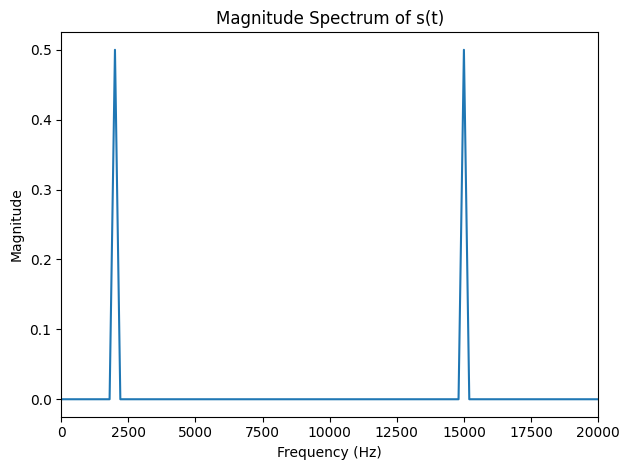

In [4]:
"""
Questão 1
"""

import numpy as np
import matplotlib.pyplot as plt

# Parameters
fs = 100000  # Sampling frequency in Hz
duration = 0.005  # 5 ms for clearer time-domain view
t = np.arange(0, duration, 1/fs)  # Time vector

# Signals
m = np.sin(2 * np.pi * 2000 * t)        # 2 kHz message sine wave
c = np.cos(2 * np.pi * 15000 * t)       # 15 kHz carrier cosine wave
s = m + c                                # Sum of message and carrier



# Frequency-domain plot (magnitude spectrum)
X = np.fft.fft(s)
freqs = np.fft.fftfreq(len(X), 1/fs)

# Only positive frequencies
pos_mask = freqs >= 0
plt.figure()
plt.plot(freqs[pos_mask], np.abs(X[pos_mask]) / len(X))
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.title("Magnitude Spectrum of s(t)")
plt.xlim(0, 20000)  # Show up to 20 kHz
plt.tight_layout()
plt.show()


Como minha banda de transmissao permitida e somente entre 12 kHz ate 18kHz, eu nao poderia ter esse pico no grafico de 2kHz, pois eu estaria "invadindo" uma badna de frequencia destinada para outra pessoa

Exercicio 2) banda minima = 4kHz

fc-fm = 15-2 = 13
fc+fm = 15+2 = 17

17-13 = 4

Ex3

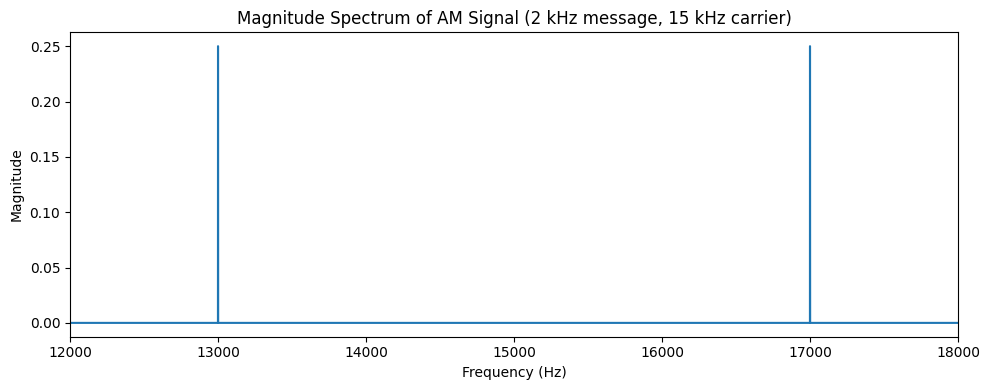

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
fs = 44100  # Sampling frequency in Hz
duration = 2.0  # Signal duration in seconds
t = np.arange(0, duration, 1/fs)  # Time vector

# Signals
m = np.sin(2 * np.pi * 2000 * t)     # Message sine wave at 2 kHz
c = np.cos(2 * np.pi * 15000 * t)    # Carrier sine wave at 15 kHz
s = m * c                             # AM modulation by pointwise multiplication

# Compute FFT
N = len(s)
S = np.fft.fft(s)
freqs = np.fft.fftfreq(N, 1/fs)

# Only positive frequencies
pos_mask = freqs >= 0
freqs_pos = freqs[pos_mask]
S_mag = np.abs(S[pos_mask]) / N

# Plot magnitude spectrum
plt.figure(figsize=(10, 4))
plt.plot(freqs_pos, S_mag)
plt.xlim(12000, 18000)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.title("Magnitude Spectrum of AM Signal (2 kHz message, 15 kHz carrier)")
plt.tight_layout()
plt.show()


Ex4

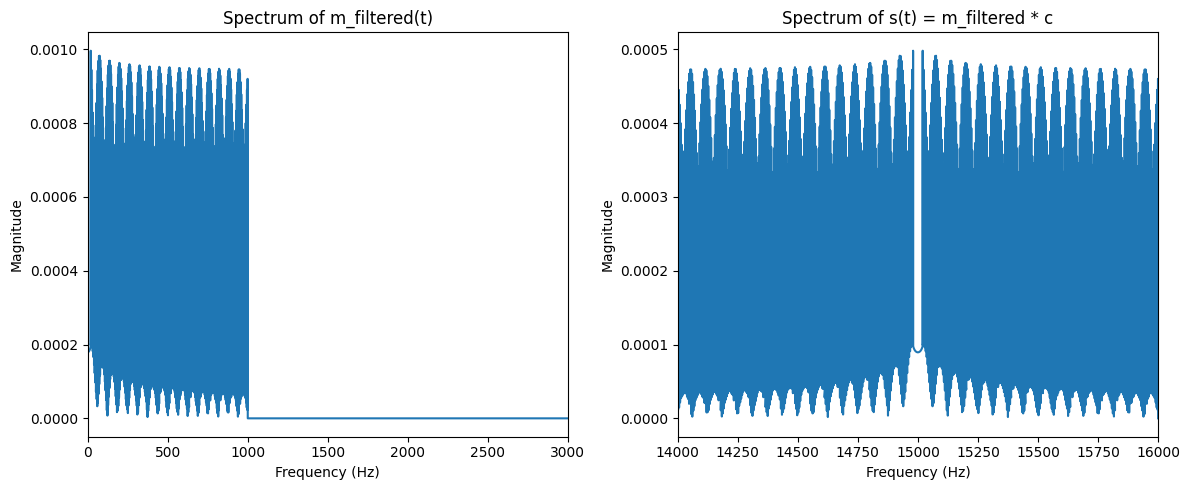

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
fs = 44100          # Sampling frequency
duration = 2.0      # Duration in seconds
t = np.arange(0, duration, 1/fs)

# Construct m(t) as sum of sine waves from 20 Hz to 2000 Hz
freqs = np.linspace(20, 2000, 500)  # 100 components
m = np.zeros_like(t)
for f in freqs:
    m += np.sin(2 * np.pi * f * t)
m /= len(freqs)  # Normalize amplitude

# Design a low-pass filter via FFT to cutoff at 1 kHz
M = np.fft.fft(m)
freq_axis = np.fft.fftfreq(len(M), 1/fs)
cutoff = 1000  # Hz
# Zero out components above cutoff
M_filtered = M.copy()
M_filtered[np.abs(freq_axis) > cutoff] = 0
m_filtered = np.fft.ifft(M_filtered).real

# Carrier
c = np.cos(2 * np.pi * 15000 * t)

# Modulate
s = m_filtered * c

# Compute spectrum
S = np.fft.fft(s)
freqs_S = np.fft.fftfreq(len(S), 1/fs)
mask = freqs_S >= 0

# Plot filtered message spectrum and modulated spectrum
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(freq_axis[freq_axis >= 0], np.abs(M_filtered[freq_axis >= 0]) / len(M_filtered))
plt.title("Spectrum of m_filtered(t)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.xlim(0, 3000)
     
plt.subplot(1, 2, 2)
plt.plot(freqs_S[mask], np.abs(S[mask]) / len(S))
plt.title("Spectrum of s(t) = m_filtered * c")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.xlim(14000, 16000)

plt.tight_layout()
plt.show()


Ex5)

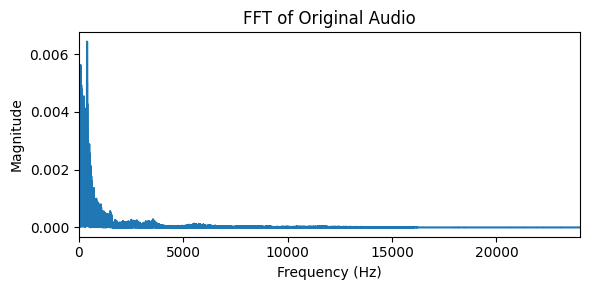

Original audio playback:


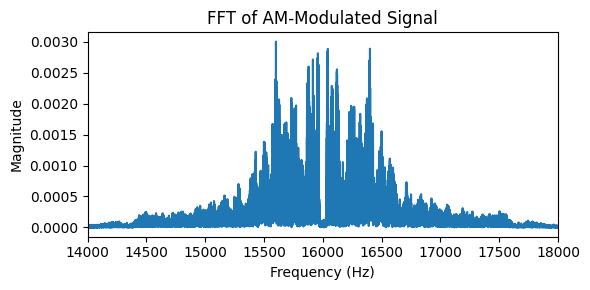

Modulated audio playback:


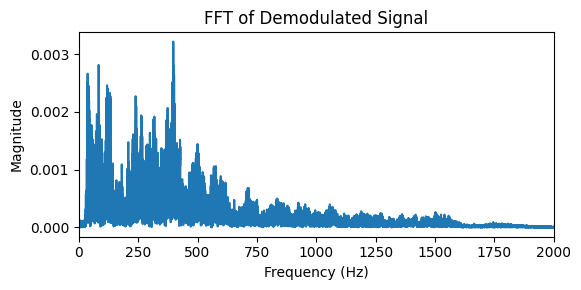

Demodulated audio playback:


In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import butter, filtfilt
from IPython.display import Audio

# --- Parameters ---
filename = 'Audio_P7.wav'
carrier_freq = 16000  # 16 kHz
band_low, band_high = 14000, 18000
lp_cutoff = 2000  # low-pass cutoff for demodulation/filtering (Hz)
filter_order = 6

# Read audio
fs, audio = wavfile.read(filename)
# If stereo, take one channel
if audio.ndim > 1:
    audio = audio[:, 0]
# Normalize
audio = audio.astype(float)
audio /= np.max(np.abs(audio))

# Time vector
N = len(audio)
t = np.arange(N) / fs

# FFT helper
def plot_fft(sig, fs, title, xlim=None):
    N = len(sig)
    S = np.fft.fft(sig)
    freqs = np.fft.fftfreq(N, 1/fs)
    mask = freqs >= 0
    plt.figure(figsize=(6,3))
    plt.plot(freqs[mask], np.abs(S[mask]) / N)
    plt.title(title)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude")
    if xlim:
        plt.xlim(xlim)
    plt.tight_layout()
    plt.show()

# Design low-pass filter for message band-limiting
def butter_lowpass(cutoff, fs, order):
    nyq = 0.5 * fs
    norm_cutoff = cutoff / nyq
    b, a = butter(order, norm_cutoff, btype='low')
    return b, a

# 1) FFT of original audio
plot_fft(audio, fs, "FFT of Original Audio", xlim=(0, fs/2))
print("Original audio playback:")
display(Audio(audio, rate=fs))

# 2) Generate carrier
carrier = np.cos(2 * np.pi * carrier_freq * t)

# 3) Pre-filter original to fit into sideband limits (<=2 kHz)
b_lp, a_lp = butter_lowpass(lp_cutoff, fs, filter_order)
audio_filtered = filtfilt(b_lp, a_lp, audio)

# AM modulation
modulated = audio_filtered * carrier

# 4) FFT of modulated signal
plot_fft(modulated, fs, "FFT of AM-Modulated Signal", xlim=(band_low, band_high))

# 5) Playback modulated audio
print("Modulated audio playback:")
display(Audio(modulated, rate=fs))

# 6) Demodulation (multiply by carrier and low-pass filter)
demod_raw = modulated * carrier
demod = filtfilt(b_lp, a_lp, demod_raw)

# 7) FFT of demodulated signal
plot_fft(demod, fs, "FFT of Demodulated Signal", xlim=(0, lp_cutoff))

# 8) Playback demodulated audio
print("Demodulated audio playback:")
display(Audio(demod, rate=fs))


EX6)

Tc = 1/fc = 1/2.4GHz = 0.42ns
0.42*2 = 0.84ns

baud rate= 1/0.84ns = 1,2G

logbase2(64) = 6bits por simbolo

taxa de bits = 6*1,2G = 7,2Gb/s

=900MB/s



Ex7)

Bits por símbolo: log₂(256) = 8 bits/símbolo
Período da portadora: Tc = 1 / 2,4×10^9 ≈ 4,17×10^-10 s
Duração de cada símbolo: Ts = 10·Tc = 4,17×10^-9 s
Taxa de símbolos: Rs = 1 / Ts = 240×10^6 símbolos/s
Taxa de bits: Rb = Rs·8 = 1,92×10^9 bits/s = 1,92 Gb/s
Taxa de bytes: Rb / 8 = 240×10^6 B/s = 240 MB/s
Tempo para transmitir 480 MB: t = 480 MB / 240 MB/s = 2 s